In [135]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
import time

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from sys import getsizeof

In [208]:
SEED = 42
np.random.seed(SEED)
torch.seed = SEED

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
#much faster and clear
class Flatten:
    def __call__(self, img):
        return img.flatten()

In [4]:
# class Normalize:
#     def __call__(self, img):
#         img = np.array(img)
#         return (img - img.min()) / (img.max() - img.min()) - 0.5

In [5]:
# import torchvision
# from torchvision import datasets

# class Normalize:
#     def __call__(self, img):
#         img = np.array(img)
#         return (img - img.min()) / (img.max() - img.min()) - 0.5
    
# class Flatten:
#     def __call__(self, img):
#         # 1х28х28 -> 28х28
#         img = img.squeeze()
#         n, m = img.shape
#         b = np.zeros(shape=(n*m))
#         for i in range(n):
#             for j in range(m):
#                 b[i*m + j] = img[i][j]
#         return b

# transforms = torchvision.transforms.Compose([
#     Normalize(),
#     Flatten(),
# ])

# train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms)

# Data

In [6]:
N = 28
NUM_CLASSES = 10
CLASSES = list(range(NUM_CLASSES))
SEED = 42

In [7]:
transforms = torchvision.transforms.Compose([
    ToTensor(),
    Normalize((0.5, ), (1,)),
    Flatten(),
])

In [8]:
class OneHotEncoder():
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.classes = list(range(num_classes))
        self.mapping = {}
        for i in range(self.num_classes):
            self.mapping[self.classes[i]] = i
        
    def __call__(self, label):
        vec = np.zeros(self.num_classes, dtype=int)
        vec[self.mapping[label]] = 1
        return vec

target_transoforms = torchvision.transforms.Compose([
    OneHotEncoder(NUM_CLASSES),
])

In [609]:
# train_dataset = datasets.FashionMNIST(
#     root='data', train=True, download=True, transform=transforms, target_transform=target_transoforms
# )
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms, target_transform=target_transoforms)
# test_loader = DataLoader(
#     Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)

In [9]:
FASION_CLASSES = datasets.FashionMNIST(
    root='data', train=True, download=True, transform=transforms, target_transform=target_transoforms
).classes

In [221]:
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms, target_transform=target_transoforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms, target_transform=target_transoforms)
test_loader = DataLoader(
    Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)

In [11]:
CLASSES = train_dataset.classes

In [12]:
for img, label in test_loader:
    break

7 - seven


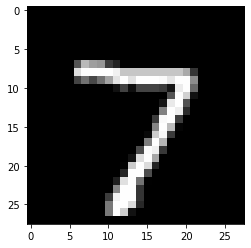

In [13]:
imshow(img[0].reshape(N, N), label=CLASSES[label[0].argmax().item()])

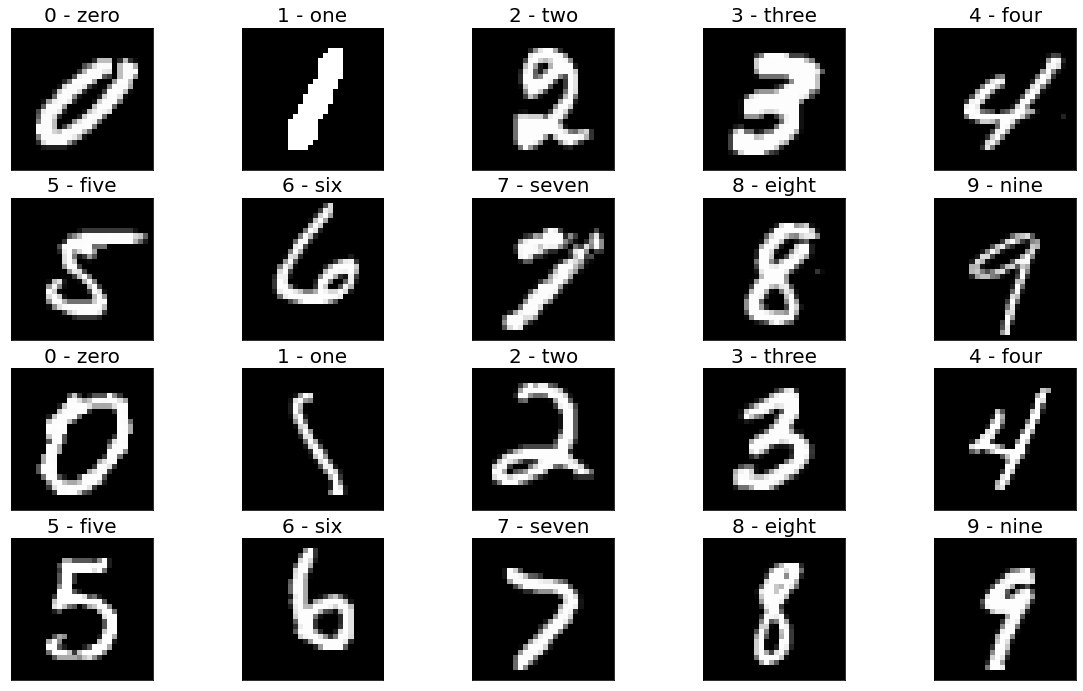

In [15]:
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(20, 12)) 
NROWS = 4
NCOLS = 5

for idx in np.arange(NROWS*NCOLS):
    images, labels = next(iter(train_loader))
    for img, label in zip(images, labels):
        if label.argmax().item() == idx % 10:
            break
    ax = fig.add_subplot(NROWS, NCOLS, idx+1, xticks=[], yticks=[])
    plt.imshow(img.reshape(N, N), cmap='gray')
    ax.set_title(CLASSES[label.argmax().item()], fontsize=20)
#     plt.imshow(images[idx].reshape(N, N), cmap='gray')
#     ax.set_title(CLASSES[labels[idx].item()])
plt.savefig('mnist')

In [16]:
all_labels = []
for imgs, labels in train_loader:
    for label in labels:
        all_labels.append(label.argmax().item())

In [17]:
pd.Series(all_labels).value_counts(1)

In [639]:
# fashion_all_labels = all_labels

In [646]:
CLASSES = list(range(10))

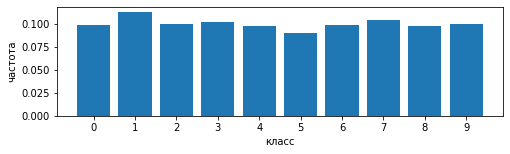

In [647]:
plt.figure(figsize=(8, 2))
plt.bar(CLASSES, np.bincount(all_labels)/len(all_labels))
plt.xticks(CLASSES)
plt.ylabel('частота')
plt.xlabel('класс')
plt.savefig('fashion_mnist_distrib', dpi=300)

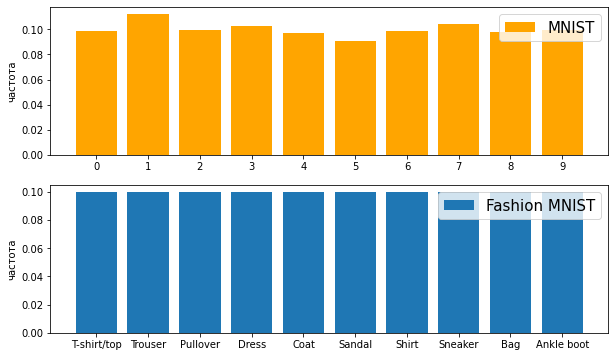

In [668]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 6))

axs[0].bar(CLASSES, np.bincount(all_labels)/len(all_labels), color='orange')
axs[0].set_xticks(CLASSES)
axs[0].set_ylabel('частота')
axs[0].legend(['MNIST'], prop={'size': 15}, loc='upper right')


axs[1].bar(CLASSES, np.bincount(fashion_all_labels)/len(fashion_all_labels))
axs[1].set_xticklabels(FASION_CLASSES, )
axs[1].set_xticks(CLASSES)
axs[0].set_xticks(CLASSES)
axs[1].set_ylabel('частота')
axs[1].legend(['Fashion MNIST'], prop={'size': 15}, loc='upper right')
plt.savefig('distrib', dpi=300)

# Activations

In [18]:
class Tanh():
    def forward(self, x):
        self.old_y = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return self.old_y
    
    def backward(self, grad):
        return (1 - self.old_y**2) * grad

In [19]:
class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1 + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1 - self.old_y) * grad

In [20]:
class ReLU():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x, 0, None)

    def backward(self, grad):
        return np.where(self.old_x>0, grad, 0)

In [21]:
class Softmax():
    def forward(self,x):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1)[:,np.newaxis]
        return self.old_y

    def backward(self,grad):
        return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,np.newaxis])

In [22]:
a = Sigmoid()
x = np.linspace(-8, 8, 100)

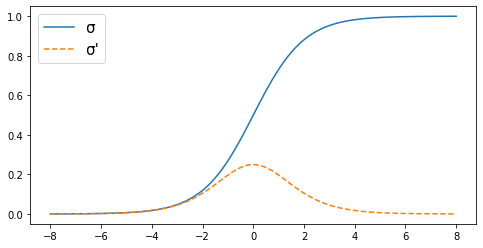

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(x, a.forward(x))
plt.plot(x, a.backward(1), '--')
plt.legend(['σ','σ\''], prop={'size': 15})
plt.savefig('sigmoid')

In [25]:
# activations = [Sigmoid(), ReLU(), Tanh()]
# fig, axs = plt.subplots(nrows=len(activations), figsize=(10, 15))
# x = np.linspace(-5, 5, 100)

# for i, activation in enumerate(activations):
#     axs[i].plot(activation.forward(x))
#     axs[i].plot(activation.backward(1))
#     axs[i].legend([activation.__class__.__name__, 'd_'+ activation.__class__.__name__], prop={'size': 15})

# Costs

In [46]:
class MSE():
    def forward(self, x, y):
        self.old_x = x
        self.old_y = y
        return (1/2 * np.square(x-y)).mean()
    
    def backward(self):
        return self.old_x - self.old_y

# Layer

In [29]:
class Linear():
    def __init__(self, n_in, n_out):
        self.w = np.random.randn(n_in, n_out) * np.sqrt(2/n_in)
        self.b = np.zeros(n_out)

    def forward(self, x):
        self.old_x = x
        return np.dot(x, self.w) + self.b

    def backward(self, grad):
        self.grad_b = grad.mean(axis=0)
        bs = grad.shape[0]
        self.grad_w = (self.old_x.T @ grad) / bs
        return np.dot(grad, self.w.T)

# Optimizer

In [185]:
class SGD():
    def __init__(self, lr=0.01):
        self.lr = lr

    def init_params(self, model):
        self.layers = [l for l in model.layers if type(l) == Linear]

    def step(self):
        for layer in self.layers:
            layer.w -= self.lr * layer.grad_w
            layer.b -= self.lr * layer.grad_b
            
    def __sizeof__(self):
        size = 0
        return 0

In [187]:
class Momentum():
    def __init__(self, lr=0.01, momentum=0.6):
        self.m = momentum
        self.lr = lr
        
    def init_params(self, model):
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
            
    def step(self):
        for i, layer in enumerate(self.layers):
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * layer.grad_b
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]
            
    def __sizeof__(self):
        size = 0
        for w, b in zip(self.velocity_w, self.velocity_b):
            size += getsizeof(w)
            size += getsizeof(b)
        return size

In [188]:
class Nesterov():
    def __init__(self, lr=0.01, momentum=0.6):
        self.m = momentum
        self.lr = lr
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
        
    def step(self):
        # создаем копию модели
        model_ahead = deepcopy(self.model)
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        # совершает шаг, получая модель из "будущего"
        for i, layer in enumerate(ahead_layers):
            layer.w -= self.m * self.velocity_w[i] 
            layer.b -= self.m * self.velocity_b[i]
        # считаем новые градиенты
        model_ahead.loss(self.model.cur_x, self.model.cur_y)
        model_ahead.backward()
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        # к старым слоям применяем новые градиенты
        for i, (ahead_layer, layer) in enumerate(zip(ahead_layers, self.layers)):
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * ahead_layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * ahead_layer.grad_b
            
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]
            
    def __sizeof__(self):
        size = 0
        for w, b in zip(self.velocity_w, self.velocity_b):
            size += getsizeof(w)
            size += getsizeof(b)
        for l in self.layers:
            size += getsizeof(l.w)
            size += getsizeof(l.b)
        return size

In [189]:
class AdaGrad():
    def __init__(self, lr=1):
        self.lr = lr
        self.eps = 1e-8
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):            
            self.N_w[i] += layer.grad_w ** 2 
            self.N_b[i] += layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)
            
    def __sizeof__(self):
        size = 0
        for w, b in zip(self.N_w, self.N_b):
            size += getsizeof(w)
            size += getsizeof(b)
        return size

In [190]:
class RMSprop():
    def __init__(self, lr=0.01, decay=0.9):
        self.lr = lr
        self.decay = decay
        self.eps = 1e-8
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):            
            self.N_w[i] = self.decay * self.N_w[i] + (1-self.decay) * layer.grad_w ** 2
            self.N_b[i] = self.decay * self.N_b[i] + (1-self.decay) * layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)
    
    def __sizeof__(self):
        size = 0
        for w, b in zip(self.N_w, self.N_b):
            size += getsizeof(w)
            size += getsizeof(b)
        return size

In [191]:
class Adam():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-8
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)
    
    def __sizeof__(self):
        size = 0
        for w, b in zip(self.N_w, self.N_b):
            size += getsizeof(w)
            size += getsizeof(b)
        
        for w, b in zip(self.M_w, self.M_b):
            size += getsizeof(w)
            size += getsizeof(b)
        return size

# Model 

In [193]:
class Model():
    def __init__(self, layers, cost, optimizer):
        self.layers = layers
        self.cost = cost
        self.optimizer = optimizer
        self.optimizer.init_params(self)
        
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x), y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1, -1, -1):
            grad = self.layers[i].backward(grad)
            
            
#     def train(self, train_loader, epochs):
#         # итерация по эпохам
#         for epoch in range(epochs):
#             # итерация по пакетам
#             for x, y in train_loader:
#                 # прямой проход и рассчет потерь
#                 self.loss(x, y)
#                 # обратный проход, накопление градиентов
#                 self.backward()
#                 # шаг оптимизатора
#                 self.optimazier.step()
                

    def train(self, train_loader, test_loader, epochs, num_samples=10_000, verbose=16):
        train_accs = []
        test_accs = []
        train_losses = []
        test_losses = []
        times = []
        for epoch in tqdm(range(epochs)):
            samples = 0
            self.cur_epoch = epoch
            for i, (img, label) in enumerate(train_loader):
                bs = img.shape[0]
                x, y = img.numpy(), label.numpy()
                self.cur_x, self.cur_y = x, y
                
                # train loss calc
                train_loss = self.loss(x, y)
                self.backward()
                
                # train preds calc acc
                train_preds = np.argmax(np.array(self.forward(x)), axis=1)
                train_labels = label.argmax(axis=1).numpy()
                
                t = time.time()
                self.optimizer.step()
                times.append(time.time() - t)

                if i % verbose == 0:
                    train_accs.append(sum(train_labels == train_preds) / len(train_preds))
                    train_losses.append(train_loss)
                    
                    test_acc, test_loss = self.validate(test_loader)
                    test_accs.append(test_acc)
                    test_losses.append(test_loss)

                samples += bs
                
                if samples > num_samples:
                    break
            
        return train_accs, train_losses, test_accs, test_losses, times
    
    def validate(self, loader):
        losses = []
        accs = []
        for img, label in loader:
            bs = img.shape[0]
            y = label.numpy()
            x = img.numpy()
            
            preds = np.argmax(np.array(self.forward(x)), axis=1)
            labels = label.argmax(axis=1).numpy()
            
            accs.append(sum(labels == preds) / len(preds))
            losses.append(self.loss(x, y))
            
        return np.mean(accs), np.mean(losses)

In [214]:
BATCH_SIZE = 64
DATASET_NAME = train_dataset.__class__.__name__
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [195]:
layers = [Linear(784, 10), Sigmoid()]

In [227]:
EPOCHS = 40
LRS = [0.001, 0.01, 0.1, 1]
LAYERS = [
    [Linear(784, 100), Sigmoid(), Linear(100, 10)],
    [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)],
    [Linear(784, 256), Sigmoid(), Linear(256, 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, 10)],
]
LAYER_NAMES = [
    '784-100-10',
    '784-100-100-10',
    '784-256-128-64-10',
]

In [228]:
df = pd.DataFrame(
    columns=[
        'optim', 'dataset', 'epochs', 'name',
        'best_epoch', 'lr',
        'time', 'memory',
        'best_accuracy', 'best_loss',
        'train_accuracies', 'train_losses', 
        'test_accuracies', 'test_losses'
    ]
)

In [233]:
names = []

In [229]:
for lr in LRS:
    OPTIMIZERS = [
        SGD(lr),
        Momentum(lr, momentum=0.9),
        Nesterov(lr, momentum=0.9),
        AdaGrad(lr),
        RMSprop(lr, decay=0.9),
        Adam(lr, beta1=0.9, beta2=0.99),
    ]
    for arch_name, layers in zip(LAYER_NAMES, LAYERS):
        for optim in OPTIMIZERS:
            model = Model(
                layers=deepcopy(layers),
                cost=MSE(),
                optimizer=deepcopy(optim),
            )
            train_result = model.train(
                train_loader, test_loader, EPOCHS, num_samples=10_000, verbose=100
            )
            train_accs, train_losses, test_accs, test_losses, times = train_result
            memory = model.optimizer.__sizeof__()
            df = df.append(
                {
                    'optim': optim.__class__.__name__,
                    'arch': arch_name,
                    'dataset': DATASET_NAME,
                    'epochs': EPOCHS,
                    'best_epoch': np.argmin(test_losses),
                    'lr': lr,
                    'time': np.mean(times),
                    'memory': memory,
                    'best_accuracy': np.max(test_accs),
                    'best_loss': np.min(test_losses),
                    'train_accuracies': train_accs,
                    'train_losses': train_losses,
                    'test_accuracies': test_accs,
                    'test_losses': test_losses,
                },
                ignore_index=True,
            )

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [247]:
df.to_csv('results.csv', index=False)

In [248]:
styles = [
    (5, (10, 3)),
    ':',
    '--',
    '-.',
    '-',
    (0, (3, 1, 1, 1, 1, 1)),
]

In [250]:
list(set(names))

['784-256-128-64-10', '784-100-100-10', '784-100-10']

In [262]:
df[(df.arch == '784-100-10') & (df.lr == 0.001)]

,optim,dataset,epochs,best_epoch,lr,time,memory,best_accuracy,best_loss,train_accuracies,train_losses,test_accuracies,test_losses,arch
0,SGD,MNIST,40,79,0.001,0.000088,0,0.722656,0.028505,"[0.09375, 0.140625, 0.1875, 0.234375, 0.296875...","[0.292534451307277, 0.04888752817402784, 0.047...","[0.096484375, 0.1353515625, 0.1521484375, 0.16...","[0.2729138012984686, 0.05182411264641985, 0.05...",784-100-10
1,Momentum,MNIST,40,79,0.001,0.000156,636528,0.846875,0.020697,"[0.765625, 0.734375, 0.703125, 0.75, 0.8125, 0...","[0.027256619149800786, 0.02735691223701061, 0....","[0.7171875, 0.72890625, 0.740625, 0.7435546875...","[0.028458748817765535, 0.02768803738005391, 0....",784-100-10
2,Nesterov,MNIST,40,79,0.001,0.003940,1273056,0.861328,0.018413,"[0.875, 0.8125, 0.90625, 0.828125, 0.875, 0.81...","[0.016729052350943092, 0.01909286634726819, 0....","[0.8458984375, 0.8478515625, 0.8419921875, 0.8...","[0.02069912860482261, 0.020660426048646867, 0....",784-100-10
3,AdaGrad,MNIST,40,79,0.001,0.000241,636528,0.889648,0.014808,"[0.90625, 0.859375, 0.8125, 0.765625, 0.875, 0...","[0.01670702841693385, 0.017991489193666537, 0....","[0.694921875, 0.854296875, 0.8533203125, 0.858...","[0.04508614357646304, 0.01818659294505041, 0.0...",784-100-10
4,RMSprop,MNIST,40,78,0.001,0.000292,636528,0.954883,0.005910,"[0.921875, 0.890625, 0.796875, 0.90625, 0.9218...","[0.0123396068177394, 0.01660199708035249, 0.02...","[0.4583984375, 0.8533203125, 0.8697265625, 0.8...","[0.24351416216411642, 0.017170592703176252, 0....",784-100-10
5,Adam,MNIST,40,79,0.001,0.000820,1273056,0.967578,0.004994,"[0.921875, 0.96875, 0.96875, 0.953125, 0.95312...","[0.006550555888184009, 0.00490205453362354, 0....","[0.948046875, 0.9470703125, 0.95, 0.9490234375...","[0.00647862050860327, 0.006039235592454322, 0....",784-100-10


In [578]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [264]:
LAYER_NAMES

['784-100-10', '784-100-100-10', '784-256-128-64-10']

In [590]:

ARCH = '784-100-10'
# ARCH = '784-256-128-64-10'

In [591]:
LRS

[0.001, 0.01, 0.1, 1]

In [592]:
LR = 0.001

In [646]:
# subdf = df[(df.arch == ARCH) & (df.lr == LR)]
subdf = df[df.dataset == 'FashionMNIST']

In [618]:
df.groupby(['optim', 'arch'])['best_accuracy'].max().groupby('optim').mean()

optim
AdaGrad     0.977930
Adam        0.975130
Momentum    0.975130
Nesterov    0.975781
RMSprop     0.965365
SGD         0.973177
Name: best_accuracy, dtype: float64

In [594]:
# subdf = df[(df.arch == ARCH) & (df.optim=='Adam')]

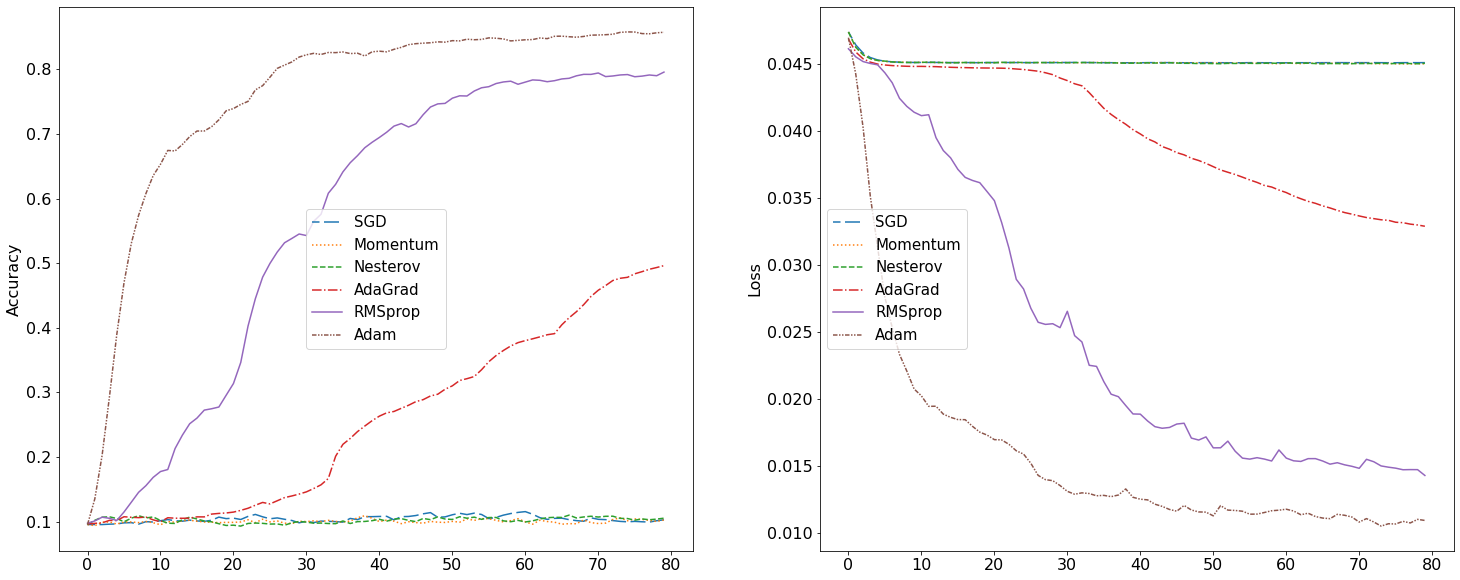

In [648]:
part = 'test'
SWITCH = 0
figsize = (25, 10)
fig, axs = plt.subplots(1, 2, figsize=figsize)
# axs = axs.ravel()
names = subdf.optim.values.copy()
f = True
plt.rcParams['font.size'] = '16'
for name, style in zip(names, styles):
    axs[SWITCH-0].plot(smooth(subdf[subdf.optim == name][f'{part}_accuracies'].values[0], 0.7), linestyle=style)
    axs[SWITCH-0].legend(names, prop={'size': 15})
    axs[SWITCH-0].set(ylabel='Accuracy')
    axs[SWITCH-1].plot(smooth(subdf[subdf.optim == name][f'{part}_losses'].values[0], 0.5), linestyle=style)
    axs[SWITCH-1].set(ylabel='Loss')
    axs[SWITCH-1].legend(names, prop={'size': 15})

# lr_legend = plt.legend('lr', loc=4)
plt.savefig('3_layer_001_lr_fm', dpi=200)

In [649]:
COLS = ['optim', 'time', 'best_accuracy', 'best_loss']

In [650]:
subdf[COLS]

,optim,time,best_accuracy,best_loss
72,SGD,0.000189,0.119141,0.045077
73,Momentum,0.000352,0.118164,0.044989
74,Nesterov,0.008778,0.118164,0.044984
75,AdaGrad,0.000560,0.503125,0.032790
76,RMSprop,0.000692,0.808984,0.013851
77,Adam,0.002131,0.864258,0.010202


In [533]:
def calc_params(model):
    # учитываем только полносвязные слои
    layers = [l for l in model.layers if type(l) == Linear]
    params = 0
    # обход слоев
    for layer in layers:
        # получаем кол-во входных и выходных нейронов
        in_p, out_p = layer.w.shape
        # перемножаем in_p и out_p, получая размер матрицы w
        # out_p - размер порога b
        params += in_p * out_p + out_p
    return params

In [538]:
model_params = [
    calc_params(Model(layers, MSE(), SGD())) for layers in LAYERS
]

In [539]:
model_params

[79510, 89610, 242762]

In [542]:
model_params[1] / model_params[0]

1.1270280467865676

In [619]:
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms, target_transform=target_transoforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms, target_transform=target_transoforms)
test_loader = DataLoader(
    Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)

In [623]:
DATASET_NAME = train_dataset.__class__.__name__

In [620]:
lr = 0.01
OPTIMIZERS = [
    SGD(lr),
    Momentum(lr, momentum=0.9),
    Nesterov(lr, momentum=0.9),
    AdaGrad(lr),
    RMSprop(lr, decay=0.9),
    Adam(lr, beta1=0.9, beta2=0.99),
]

In [634]:
optim = Adam(lr, beta1=0.9, beta2=0.99)

In [624]:
layers = LAYERS[-1]
arch_name = LAYER_NAMES[-1]

In [644]:
for optim in OPTIMIZERS:
    model = Model(
        layers=deepcopy(layers),
        cost=MSE(),
        optimizer=deepcopy(optim),
    )
    train_result = model.train(
        train_loader, test_loader, EPOCHS, num_samples=10_000, verbose=100
    )
    train_accs, train_losses, test_accs, test_losses, times = train_result
    memory = model.optimizer.__sizeof__()
    df = df.append(
        {
            'optim': optim.__class__.__name__,
            'arch': arch_name,
            'dataset': DATASET_NAME,
            'epochs': EPOCHS,
            'best_epoch': np.argmin(test_losses),
            'lr': lr,
            'time': np.mean(times),
            'memory': memory,
            'best_accuracy': np.max(test_accs),
            'best_loss': np.min(test_losses),
            'train_accuracies': train_accs,
            'train_losses': train_losses,
            'test_accuracies': test_accs,
            'test_losses': test_losses,
        },
        ignore_index=True,
    )

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [635]:
model = Model(
    layers=deepcopy(layers),
    cost=MSE(),
    optimizer=deepcopy(optim),
)

In [636]:
train_result = model.train(
    train_loader, test_loader, EPOCHS, num_samples=10_000, verbose=100
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [638]:
train_accs, train_losses, test_accs, test_losses, times = train_result